# Introduction to Benders Decomposition

Author: Mathieu Tanneau, <mathieu [dot] tanneau [at] gmail [dot] com>

This notebook is an introduction to Benders decomposition,
    using artificial instances of the uncapacitated facility location problem.

The notebook is released under the following terms:
* the _code_ is released under the [MIT license](https://mit-license.org/)
* the _text_ is released under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/)

### Julia & compilation

Julia code is compiled the first time it is executed.
Thus, it is recommended to always execute code twice, to ensure the reported time does not include any compilation.

For further details, see the [Julia documentation](https://docs.julialang.org/en/v1/) and its [Performance tips section](https://docs.julialang.org/en/v1/manual/performance-tips/).

In [1]:
# Activate the Julia environment defined in the Project.toml file
using Pkg
Pkg.activate(joinpath(@__DIR__, "..", ".."))

# The following line ensures that all packages are installed
# You can comment it out if you've already run this notebook at least once.
Pkg.instantiate()  

  Activating project at `~/Git/or_tutorials`


In [2]:
# Load standard library packages
using LinearAlgebra
using Printf
using Random

using Plots

# JuMP is a modeling language embedded in Julia
# For more details: https://jump.dev/
using JuMP

# Gurobi (https://gurobi.com) is a commercial solver; you need to download it manually.
# Then, follow installation instructions at https://github.com/jump-dev/Gurobi.jl#installation
using Gurobi
# To avoid checking out multiple Gurobi licenses, we define a global Gurobi environment,
#   which will be re-used throughout the code.
if !isdefined(Main, :GRBENV)  # Avoid re-defining a const
    const GRBENV = Gurobi.Env()
end

# HiGHS (https://github.com/ERGO-Code/HiGHS) is an open-source solver.
# Julia's package manager will automatically download and install HiGHS.
using HiGHS

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-28


# Uncapacitated Facility Location

This problem is a classical example for applying Benders decomposition.

## Problem data

The problem data is composed of
* $m$ sites where facilities may be built
* $n$ customers to be served
* the location of each customer and potential site

## Mathematical formulation

### Decision variables

\begin{align*}
    y_{i} &= 
    \left\{
       \begin{array}{cl}
           1 & \quad \text{if a facility is built at location $i$},\\
           0 & \quad \text{otherwise}
       \end{array}
    \right.
        && \forall i \in \{1, ..., m \},\\
       \ \\
    x_{i, j} &= 
    \left\{
       \begin{array}{cl}
           1 & \quad \text{if customer $j$ is served by facility $i$},\\
           0 & \quad \text{otherwise}
       \end{array}
       \right.
        &&\forall (i, j) \in \{1, ..., m \} \times \{1, ..., n\}
\end{align*}

### Constraints

* Each customer must be served by exactly one facility:
\begin{align*}
    \sum_{i} x_{i, j} & = 1, && \forall j = \{1, ..., n\}.
\end{align*}
* A facility can only serve a customer if it has been built:
\begin{align*}
    x_{i, j} & \leq y_{i}, && \forall (i,j) \in \{1, ..., m\} \times \{1, ..., n\}.
\end{align*}
* All variables are binary
\begin{align*}
    y & \in \{0, 1\}^{m},\\
    x & \in \{0, 1\}^{m \times n}.
\end{align*}

### Objective 

The objective (to be minimized) reads
\begin{align*}
    f^{T}y + \sum_{i, j} D_{i, j} x_{i, j},
\end{align*}
where
* $f_{i}$ is the cost of building a facility at location $i$,
* $D_{i, j}$ is the distance between location $i$ and customer $j$.

In [3]:
include("ufl.jl")

solve_benders_sp_fast (generic function with 1 method)

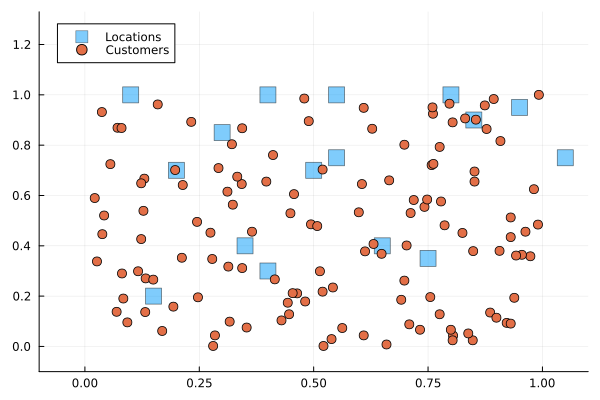

In [4]:
ufl = generate_ufl_instance(16, 128)
plot_ufl_instance(ufl)

# MIP formulation

The overall problem reads

\begin{align}
    \min_{x, y} \quad
    & \sum_{i} f_{i} y_{i} + \sum_{i, j} D_{i, j} x_{i, j}\\
    \text{s.t.} \quad
    & \sum_{i} x_{i, j} = 1, && \forall j,\\
    & x_{i, j} \leq y_{i}, && \forall (i, j),\\
    & y \in \{0, 1\}^{m},\\
    & x \in \{0, 1\}^{m \times n}.
\end{align}

Small instances can be solved efficiently with off-the-shelf MIP solvers.

In [5]:
mip = build_ufl_mip(ufl)

# ... and attach a MIP solver afterwards
# Un-comment the line you want, to choose the corresponding MIP solver
set_optimizer(mip, Gurobi.Optimizer)  # Gurobi is much faster on large instances
# set_optimizer(mip, HiGHS.Optimizer)

optimize!(mip)

sname = solver_name(mip)
stime = solve_time(mip)

println("$(sname) solved the problem in $(stime) seconds.")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-28
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2176 rows, 2064 columns and 6144 nonzeros
Model fingerprint: 0x56d7c38b
Variable types: 0 continuous, 2064 integer (2064 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 919.9480147
Presolve time: 0.01s
Presolved: 2176 rows, 2064 columns, 6144 nonzeros
Variable types: 0 continuous, 2064 integer (2064 binary)
Found heuristic solution: objective 651.2747371

Root relaxation: objective 3.087584e+02, 311 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

There are 5 facilities open.


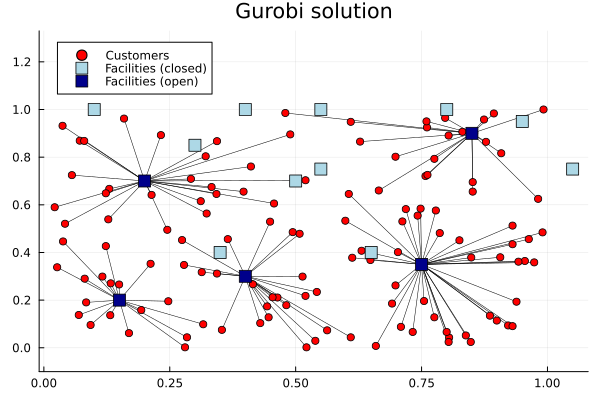

In [6]:
y_ = Bool.(round.(value.(mip[:y])))
x_ = Bool.(round.(value.(mip[:x])))
println("There are $(sum(y_)) facilities open.")

plt = plot_ufl_solution(ufl, y_, x_)
title!(plt, "$(sname) solution")
plt

# Benders Decomposition

The Benders decomposition-based formulation keeps the $y$ variables in the master problem,
and the $x$ variables in the sub-problem.

## Benders sub-problem

For fixed $y$, the sub-problem consists in assigning each customer to an open facility,
so as to minimize the sum of distances between customers and facilities.

Two important observations are in order:
1. The sub-problem is separable per customer, i.e., we can consider $n$ sub-problems: one for each customer $j$.
2. If $y$ is integer, then the integrality condition on $x$ can be dropped.
    Thus, the sub-problem is always a (continuous) linear program.

### Mathematical formulation

The Benders sub-problem for customer $j$ and current master solution $\bar{y}$ reads

\begin{align}
    SP_{j}(\bar{y}) \quad \min_{x} \quad & \sum_{i} d_{i, j} x_{j}\\
    s.t. \quad
        & \sum_{i} x_{i, j} = 1 &&[\mu]\\
        & \forall i, \ x_{i, j} \leq \bar{y}_{i} && [\lambda_{i}]\\
        & \forall i, \ 0 \leq x_{i, j} \leq 1
\end{align}

Given the sub-problem's optimal objective value $\phi_{j}(\bar{y})$ and dual solution $\lambda$,
the Benders cut has the form
$$
    \phi_{j}(y) \geq \phi_{j}(\bar{y}) + \lambda^{T}(y - \bar{y})
$$

## Master problem

The initial master problem reads

\begin{align}
    \min_{y, \theta} \quad & f^{T}y + \sum_{j} \theta_{j}\\
    s.t. \quad
    & \sum_{i} y_{i} \geq 1\\
    & y \in \{0, 1\}^{n}\\
    & \theta_{j} \geq 0 & \forall j
\end{align}

Notes:
* the constraint $\sum_{i} y_{i} \geq 1$ is not necessary, but ensures the subproblems are always feasible.
* Whether we consider a multi-cut, single-cut, or aggregated cut variant, $\theta$ has at most $n$ coordinates.
  Thus, for simplicity, we always create $n$ of them.

In [7]:
function generate_mp()
    mp = direct_model(Gurobi.Optimizer(GRBENV))

    @variable(mp, y[1:m], Bin)
    @variable(mp, θ[1:n] >= 0)

    @constraint(mp, sum(y) >= 1)

    @objective(mp, Min, dot(f, y) + sum(θ))

    # Set a few additional parameters
    set_optimizer_attribute(mp, "Threads", 1)  # Only use one thread

    return mp
end

generate_mp (generic function with 1 method)

## Benders decomposition loop

The function `solve_benders` below solves the uncapacitated facility location problem using Benders decomposition.
Its sole argument is the master problem `mp`.
Other key-word arguments are described below.

The algorithm's overall behavior is controlled by
* `niter_max`: the maximum number of BD iterations
* `seed`: A random seed, for reproducibility
* `verbose`: If zero, no log is produced.
    If `>0`, then a log is produced every `verbose` iterations, or whenever the upper bound is improved
* `ϵ_gap`: the MIP gap tolerance for convergence
* `time_limit`: the time limit, in seconds. Will be checked at the _end_ of each iteration


### Reading the logs

The logs look something like
```
Solving Benders with 32 sub-problems and 32 clusters
Iter         Primal bound         Dual bound   Gap(%)  #cuts   T-MP   T-SP T-Jump   T(s)
   0*       +2.666480e+02      +1.000000e+01   96.25%     32   0.00   0.00   0.00   0.00
   1*       +1.454178e+02      +5.883625e+01   59.54%     64   0.01   0.00   0.00   0.01
   2*       +1.337201e+02      +1.335820e+02    0.10%     65   0.04   0.00   0.00   0.04
   3*       +1.337201e+02      +1.337201e+02    0.00%     65   0.06   0.00   0.00   0.06
Found optimal solution within tolerances
```
The first line indicates the number of sub-problems and clusters.

The columns are as follows:
* `Iter` is the number of BD iterations
* `Primal bound` is the current best primal (upper) bound
* `Dual bound` is the current best dual (lower) bound
* `Gap` is the current optimality gap
* `#cuts` is the current number of cuts in the master problem
* Computing time is measured as follows
    * `T-MP` is the total time spent solving the master problem
    * `T-SP` is the total time spent solving the sub-problems
    * `T-JuMP` is the total time spent by JuMP to add constraints to the master problem
    * `T(s)` is the total elapsed time thus far

In [8]:
function solve_benders(ufl, mp;
    niter_max::Int=250,
    seed::Int=0,
    verbose::Int=1,
    ϵ_gap::Float64=1e-4,
    time_limit::Real=180,
    ϵ_root::Real=1e-3,
)
    m = ufl.m
    n = ufl.n

    # Set the random seed
    Random.seed!(seed)
    
    # Count number of clusters
    verbose > 0 && println("Solving Benders with $(n) sub-problems")
    is_mp_integer = true
    
    # Extract a few things from master problem
    y::Vector{JuMP.VariableRef} = mp[:y]
    θ::Vector{JuMP.VariableRef} = mp[:θ]
    
    # Benders main loop
    z_lb = -Inf
    z_ub = +Inf
    y_hist = []  # History of master solutions
    Z_lb = Float64[]
    Z_ub = Float64[]
    T = Float64[]

    gap = Inf
    niter = 0
    ncuts_tot = 0

    y_best = zeros(Float64, m)
    x_best = zeros(Int, n)
    solflag = false

    t_mp = 0.0
    t_sp = 0.0
    t_tot = 0.0
    t_jump = 0.0

    t0 = time()

    verbose > 0 && @printf(
        "%4s   %18s %18s  %7s %6s %6s %6s %6s %6s\n",
        "Iter",
        "Primal bound",
        "Dual bound",
        "Gap(%)",
        "#cuts",
        "T-MP",
        "T-SP",
        "T-Jump",
        "T(s)"
    )
    
    while niter < niter_max
        set_silent(mp)
        t_mp += @elapsed optimize!(mp)
        st = termination_status(mp)
        st == MOI.OPTIMAL || break

        # Get the current lower bound...
        z_mp = objective_value(mp)

        # ... and current master solution
        y_ = value.(y)
        θ_ = value.(θ)
        is_mp_integer && (y_ = round.(y_))  # make sure we have binary values
        push!(y_hist, y_)

        # Update lower bound
        z_lb = max(z_lb, z_mp)
        push!(Z_lb, z_lb)
        
        # Cut-generation loop
        ncuts = 0
        δz = -sum(θ_)
        for j in 1:n
            t_sp += @elapsed zj, λj, xj = solve_benders_sp(ufl.D[:, j], y_)
            δz += zj
            
            if (zj - θ_[j]) > 1e-6
                # Only add the cut if it violated (up to tolerance)
                t_jump += @elapsed begin
                    @constraint(mp, θ[j] ≥ zj + dot(λj, y - y_))
                end
                ncuts += 1
            end
        end
        
        ncuts_tot += ncuts

        # If improved upper bound, record the current solution
        solflag = false
        if is_mp_integer && (z_ub > z_mp + δz)
            # Trigger an improvement in the upper bound
            z_ub = z_mp + δz  # record new upper bound
            solflag = true
            y_best .= y_
        end
        push!(Z_ub, z_ub)
        
        # Log
        gap = (z_ub - z_lb) / (1e-10 + abs(z_ub))
        isnan(gap) && (gap = 1.0)
        t_tot = time() - t0
        push!(T, t_tot)
        if verbose > 0 && (solflag || (niter % verbose == 0))
            @printf(
                "%4d%1s  %+18.6e %+18.6e  %6.2f%% %6d %6.2f %6.2f %6.2f %6.2f\n",
                niter,
                ( solflag ? "*" : ""),
                z_ub,
                z_lb,
                100*gap,
                ncuts_tot,
                t_mp,
                t_sp,
                t_jump,
                t_tot
            )
            flush(stdout)
        end
        t_tot > time_limit && break
        gap < ϵ_gap && break

        niter += 1
    end

    # Final log
    if verbose > 0
        niter == niter_max && println("Maximum number of iterations reached")
        gap < ϵ_gap && println("Found optimal solution within tolerances")
        t_tot > time_limit && println("Time limit reached")
    end
    
    return y_hist, Z_lb, Z_ub, T
end

solve_benders (generic function with 1 method)

## Numerical example

The following examples illustrate various of the aforementioned settings.

For each run, the progress of the lower and upper bound are plotted against
(i) the number of BD iterations, and 
(ii) the elasped computing time.

In [9]:
ufl = generate_ufl_instance(32, 2048)
mp = build_ufl_master(ufl; optimizer=() -> Gurobi.Optimizer(GRBENV))

@time Y, Zlb, Zub, T = solve_benders(ufl, mp;
    niter_max=500,
    seed=0,
    verbose=5,
    ϵ_gap=1e-4,
    time_limit=180,
);
niter = length(Y);

Solving Benders with 2048 sub-problems


Iter         Primal bound         Dual bound   Gap(%)  #cuts   T-MP   T-SP T-Jump   T(s)
   0*       +1.531757e+04      +1.000000e+01   99.93%   2048   0.24   0.87   0.04   1.56


   1*       +6.621343e+03      +2.064824e+02   96.88%   4086   0.39   1.58   0.07   2.98


   2*       +3.941662e+03      +1.217884e+03   69.10%   5879   0.59   2.33   0.09   3.95


   3*       +2.601397e+03      +2.154314e+03   17.19%   6518   0.81   3.09   0.10   4.94


   5*       +2.595871e+03      +2.589472e+03    0.25%   6853   1.78   4.73   0.10   7.56


   6*       +2.593031e+03      +2.593031e+03    0.00%   6853   2.40   5.69   0.10   9.14


Found optimal solution within tolerances
 10.298123 seconds (40.73 M allocations: 2.256 GiB, 8.03% gc time, 23.32% compilation time: 0% of which was recompilation)


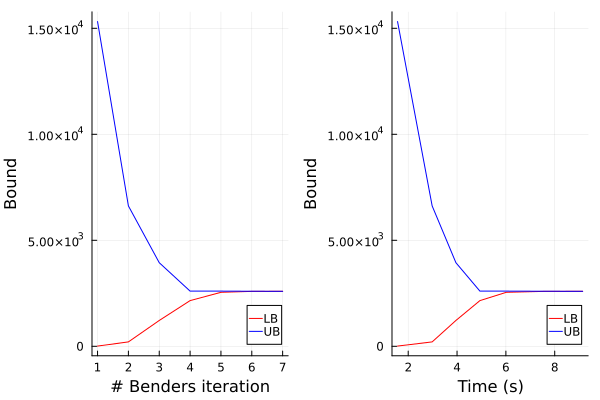

In [10]:
plt_iter = plot(
    legend=:bottomright,
    xlabel="# Benders iteration",
    ylabel="Bound",
)

plot!(plt_iter, Zlb, color=:red,  label="LB")
plot!(plt_iter, Zub, color=:blue, label="UB")

plt_time = plot(
    legend=:bottomright,
    xlabel="Time (s)",
    ylabel="Bound",
)

plot!(plt_time, T, Zlb, color=:red,  label="LB")
plot!(plt_time, T, Zub, color=:blue, label="UB")

plt = plot(plt_iter, plt_time)